In [109]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    r2_score,
)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:

def plot_sel_coeff_preds(data, dtype, name, outdir, scenarios):
    """Plot s predictions against true value, color by scenario."""
    if "ssv" in name:
        true_class = "ssv"
    elif "sdn" in name:
        true_class = "sdn"

    plt.scatter(
        data["true_sel_coeff"], data["pred_sel_coeff"], label=true_class.upper()
    )
    plt.annotate(
        f"""r^2 of {true_class.upper()}: {np.round(r2_score(data["true_sel_coeff"], data["pred_sel_coeff"]), 2)}""",
        (0.05, 0.27),
    )

    plt.legend()
    plt.xlim((0, 0.3))
    plt.ylim((0, 0.3))
    plt.title(f"{name} \n Predicted vs True Selection Coefficients")
    plt.ylabel("Predicted S")
    plt.xlabel("True S")

    plt.savefig(
        f"{outdir}/{name.replace(' ', '_')}_Timesweeper_Reg_{dtype}_selcoeffs.png"
    )
    plt.savefig(
        f"{outdir}/{name.replace(' ', '_')}_Timesweeper_Reg_{dtype}_selcoeffs.png"
    )
    plt.clf()


def plot_confusion_matrix(
    working_dir, cm, target_names, title="Confusion matrix", cmap=None, normalize=False
):
    """
    Given a sklearn confusion matrix (cm), make a nice plot.

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    outfile = title
    title = title.split("_Timesweeper")[0] + " Confusion Matrix"

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                f"{cm[i, j]:0.4f}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]:,}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}")


# Adapt the single-plots from plotting.plotting_utils to iteratively plot curves
def plot_roc(name, data, dtype, outdir):
    """Plot ROC curve by binarizing neutral/sweep."""

    # Plot sdn/ssv distinction
    sweep_idxs = np.transpose(np.array((data["true"] > 0)).nonzero())
    sweep_labs = np.array(data["true"])[sweep_idxs]

    sdn_probs = data[data["true"] > 0]["sdn_prob"]

    swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
    swp_auc_val = auc(swp_fpr, swp_tpr)
    plt.plot(
        swp_fpr,
        swp_tpr,
        label=f"{name.capitalize()} SDN vs SSV: {swp_auc_val:.4}",
    )

    # Coerce all ssvs into sweep binary pred
    labs = np.array(data["true"])
    labs[labs > 1] = 1
    pred_probs = np.sum(np.array([data["sdn_prob"], data["ssv_prob"]]).T, axis=1)

    # Plot ROC Curve
    fpr, tpr, thresh = roc_curve(labs, pred_probs)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name.capitalize()} Neutral vs Sweep AUC: {auc_val:.2}")
    
    plt.ylim((0,1.1))
    plt.xlim((0,1.1))
    plt.title(f"ROC Curve {name}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()


def plot_prec_recall(name, data, dtype, outdir):
    """Plot PR curve by binarizing neutral/sweep."""
    # Plot sdn/ssv distinction

    filt_data = data[(data["sdn_prob"] > 0.0) & (data["ssv_prob"] > 0.0)]

    sweep_idxs = np.transpose(np.array((filt_data["true"] > 0)).nonzero())
    sweep_labs = np.array(filt_data["true"])[sweep_idxs]

    # TODO FIX THIS: divide score of sweep by summed sweep prob
    # TODO FIlter out where probs of both prob are 0
    if len(np.unique(filt_data["true"])) > 2:
        sdn_probs = filt_data[filt_data["true"] > 0]["sdn_prob"] / (
            filt_data[filt_data["true"] > 0]["sdn_prob"]
            + filt_data[filt_data["true"] > 0]["ssv_prob"]
        )

        swp_prec, swp_rec, swp_thresh = precision_recall_curve(
            sweep_labs.flatten(), sdn_probs, pos_label=2
        )
        swp_auc_val = auc(swp_rec, swp_prec)
        plt.plot(
            swp_rec,
            swp_prec,
            label=f"{name.capitalize()} SDN vs SSV AUC: {swp_auc_val:.2}",
        )

    # Coerce all ssvs into sweep binary pred
    labs = np.array(data["true"])
    labs[labs > 1] = 1
    pred_probs = np.sum(np.array([data["sdn_prob"], data["ssv_prob"]]).T, axis=1)

    # Plot PR Curve for binarized labs
    prec, rec, thresh = precision_recall_curve(labs, pred_probs)
    auc_val = auc(rec, prec)
    plt.plot(rec, prec, label=f"{name.capitalize()} Neutral vs Sweep AUC: {auc_val:.2}")

    plt.title(f"PR Curve {name}")
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim((0,1.1))
    plt.xlim((0,1.1))


In [111]:
ts = pd.read_csv("ts_res/ts_centers/AFT_Timesweeper_res.csv")
ts_hft = pd.read_csv("ts_res/ts_centers/hft_Timesweeper_res.csv")
sf = pd.read_csv("sf_res/sf_res.csv")
shic_final = pd.read_csv("shic_final_res/shic_res.csv")
shic_ts = pd.read_csv("shic_tp_res/TP_SHIC_res.csv")
slattice = pd.read_csv("slattice_res/slattice_output.csv")
appwf = pd.read_csv("wfapp_results/appwf_res.csv")
wfabc = pd.read_csv("wfabc_res/wfabc.csv")

In [112]:
appwf = appwf[(appwf["s_val"] != 0.0) & (appwf["sweep"] != "neut")] 
appwf.head()


,rep,sweep,s_val,estimated_s_mean,est_std
4996,0,sdn,0.068915,0.076798,0.020254
4997,1,sdn,0.143512,0.122946,0.024981
4998,10,sdn,0.120995,0.119612,0.023672
4999,100,sdn,0.091992,0.087922,0.018696
5000,1001,sdn,0.221360,0.179191,0.033474


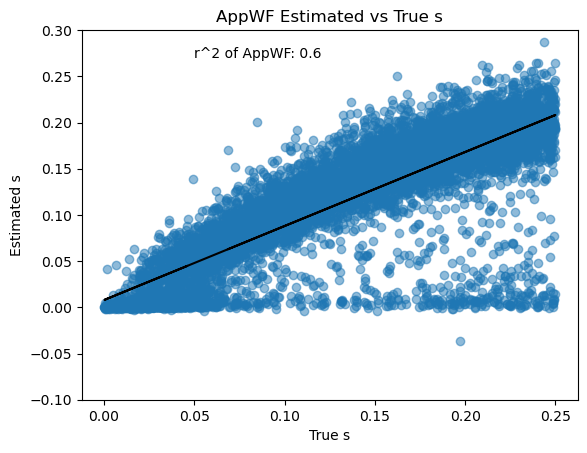

In [113]:
x = appwf["s_val"]
y = appwf["estimated_s_mean"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of AppWF: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("AppWF Estimated vs True s")
plt.savefig("appwf_selcoeffs.png")


In [114]:
wfabc = wfabc[(wfabc["s_val"] != 0.0) & (wfabc["sweep"] != "neut")] 

wfabc.dropna(inplace=True)
wfabc = wfabc[wfabc["sweep"] != "neut"]
wfabc.head()


,rep,sweep,s_val,estimated_s_mean,est_std
4996,0,sdn,0.068915,0.045691,0.036437
4997,1,sdn,0.143512,0.106145,0.039729
4998,10,sdn,0.120995,0.157122,0.047257
4999,100,sdn,0.091992,0.105670,0.043313
5000,1001,sdn,0.221360,0.136518,0.051310


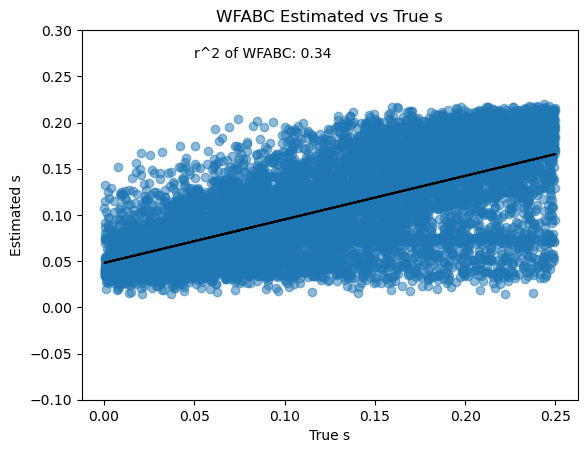

In [115]:
#WFABC
x = wfabc["s_val"]
y = wfabc["estimated_s_mean"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of WFABC: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("WFABC Estimated vs True s")
plt.savefig("wfabc_selcoeffs.png")


In [116]:
lab_dict = {"neut": 0, "sdn": 1, "ssv": 2}
ts["swp_str"] = [lab_dict[i] for i in ts["sweep"]]
class_ts = ts
ts.head()


,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str
0,0,neut,0,0.900236,0.031182,0.068582,0.0,0.023495,0.157943,0
1,1,neut,0,0.967756,0.018013,0.014232,0.0,0.023938,0.048872,0
2,10,neut,0,0.944564,0.026852,0.028584,0.0,0.023861,0.115227,0
3,100,neut,0,0.914856,0.037577,0.047567,0.0,0.018109,0.073310,0
4,1001,neut,0,0.893581,0.014559,0.091860,0.0,0.025733,0.068648,0


In [117]:
ts = ts[ts["sweep"] != "neut"]
ts["est_s"] = np.zeros(len(ts))
ts.loc[ts["swp_str"] == 1, "est_s"] = ts["sdn_sval"]
ts.loc[ts["swp_str"] == 2, "est_s"] = ts["ssv_sval"]
ts.head()

/tmp/ipykernel_2204828/431088656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts["est_s"] = np.zeros(len(ts))


,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str,est_s
5046,0,sdn,1,0.000910,0.654779,0.344311,0.068915,0.071422,0.064821,1,0.071422
5047,1,sdn,1,0.000055,0.665350,0.334596,0.143512,0.110446,0.103174,1,0.110446
5048,10,sdn,1,0.000022,0.712063,0.287915,0.120995,0.102674,0.114734,1,0.102674
5049,100,sdn,1,0.000106,0.641577,0.358317,0.091992,0.102899,0.088117,1,0.102899
5050,1001,sdn,1,0.000056,0.648474,0.351470,0.221360,0.202432,0.208670,1,0.202432


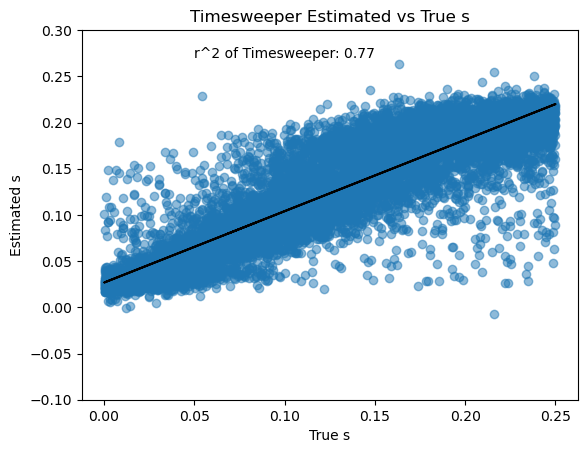

In [118]:
#Timesweeper
x = ts["s_val"]
y = ts["est_s"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of Timesweeper: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("Timesweeper Estimated vs True s")
plt.savefig("timesweeper_selcoeffs.png")


In [119]:
lab_dict = {"neut": 0, "sdn": 1, "ssv": 2}
ts_hft["swp_str"] = [lab_dict[i] for i in ts_hft["sweep"]]
class_ts = ts_hft
ts_hft.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str
0,0,neut,0,0.622819,0.079795,0.297386,0.0,0.084563,0.137496,0
1,1,neut,0,0.727708,0.096487,0.175805,0.0,0.032541,0.077407,0
2,10,neut,0,0.713442,0.083697,0.202861,0.0,0.031981,0.071435,0
3,100,neut,0,0.668812,0.136396,0.194792,0.0,0.056437,0.076022,0
4,1001,neut,0,0.692912,0.118566,0.188522,0.0,0.028734,0.057516,0


In [120]:
ts_hft = ts_hft[ts_hft["sweep"] != "neut"]
ts_hft["est_s"] = np.zeros(len(ts_hft))
ts_hft.loc[ts_hft["swp_str"] == 1, "est_s"] = ts_hft["sdn_sval"]
ts_hft.loc[ts_hft["swp_str"] == 2, "est_s"] = ts_hft["ssv_sval"]
ts_hft.head()

/tmp/ipykernel_2204828/2129214617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_hft["est_s"] = np.zeros(len(ts_hft))


,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str,est_s
5044,0,sdn,0,0.591555,0.193757,0.214688,0.068915,0.041253,0.065715,1,0.041253
5045,1,sdn,1,0.008359,0.547531,0.444110,0.143512,0.145222,0.118839,1,0.145222
5046,10,sdn,1,0.014252,0.621036,0.364712,0.120995,0.129433,0.142788,1,0.129433
5047,100,sdn,2,0.395551,0.146566,0.457883,0.091992,0.104692,0.079258,1,0.104692
5048,1001,sdn,1,0.007226,0.576001,0.416773,0.221360,0.166552,0.158942,1,0.166552


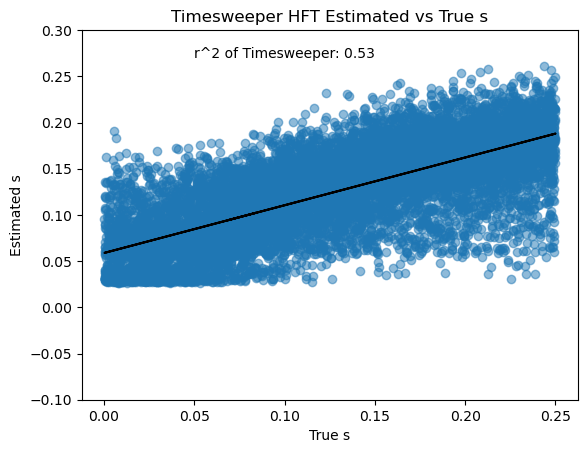

In [121]:
#Timesweeper HFT
x = ts_hft["s_val"]
y = ts_hft["est_s"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of Timesweeper: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("Timesweeper HFT Estimated vs True s")
plt.savefig("timesweeper_hft_selcoeffs.png")


In [122]:
slattice = slattice[slattice["sweep"] != "neut"]
slattice.head()


,rep,sweep,s_val,estimated_sval
5046,0,sdn,0.068915,0.033642
5047,1,sdn,0.143512,0.056026
5048,10,sdn,0.120995,0.054687
5049,100,sdn,0.091992,0.040705
5050,1001,sdn,0.221360,0.085993


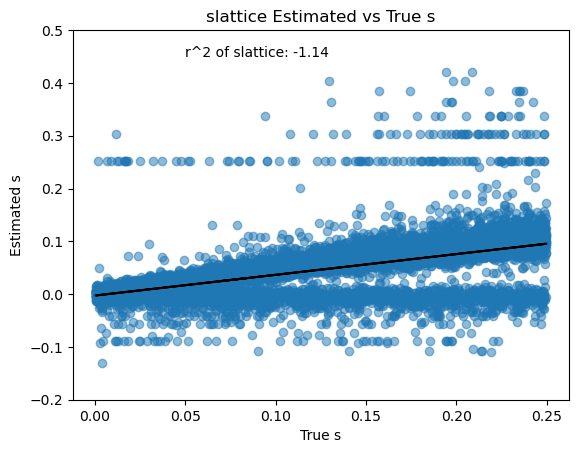

In [123]:
#Slattice
x = slattice["s_val"]
y = slattice["estimated_sval"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.2, 0.5))   
plt.annotate(
        f"""r^2 of slattice: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.45),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("slattice Estimated vs True s")
plt.savefig("slattice_selcoeffs.png")


In [124]:
lab_dict = {"neut": 0, "sdn": 1, "ssv": 2}
shic_ts["swp_str"] = [lab_dict[i] for i in shic_ts["sweep"]]
shic_ts.head()


,rep,sweep,selcoeff,pred_class,neut_prob,sdn_prob,ssv_prob,sdn_pred_s,ssv_pred_s,swp_str
0,0,neut,0.194983,0,0.520371,0.202742,0.276887,0.061183,0.059168,0
1,0,sdn,0.068915,0,0.573763,0.190137,0.236100,0.033433,0.059415,1
2,0,ssv,0.014222,0,0.440146,0.236893,0.322961,0.080455,0.102627,2
3,1,neut,0.195803,0,0.601179,0.174347,0.224474,0.048792,0.061011,0
4,1,sdn,0.143512,1,0.083108,0.482789,0.434103,0.106391,0.130415,1


In [125]:
class_shic_ts = shic_ts

shic_ts["est_s"] = np.zeros(len(shic_ts))
shic_ts = shic_ts[shic_ts["sweep"] != "neut"]
shic_ts.loc[shic_ts["swp_str"] == 1, "est_s"] = shic_ts["sdn_pred_s"]
shic_ts.loc[shic_ts["swp_str"] == 2, "est_s"] = shic_ts["ssv_pred_s"]
shic_ts.head()

,rep,sweep,selcoeff,pred_class,neut_prob,sdn_prob,ssv_prob,sdn_pred_s,ssv_pred_s,swp_str,est_s
1,0,sdn,0.068915,0,0.573763,0.190137,0.236100,0.033433,0.059415,1,0.033433
2,0,ssv,0.014222,0,0.440146,0.236893,0.322961,0.080455,0.102627,2,0.102627
4,1,sdn,0.143512,1,0.083108,0.482789,0.434103,0.106391,0.130415,1,0.106391
5,1,ssv,0.174422,0,0.490952,0.223800,0.285248,0.056728,0.075247,2,0.075247
7,2,sdn,0.177823,1,0.000094,0.693146,0.306760,0.164535,0.160230,1,0.164535


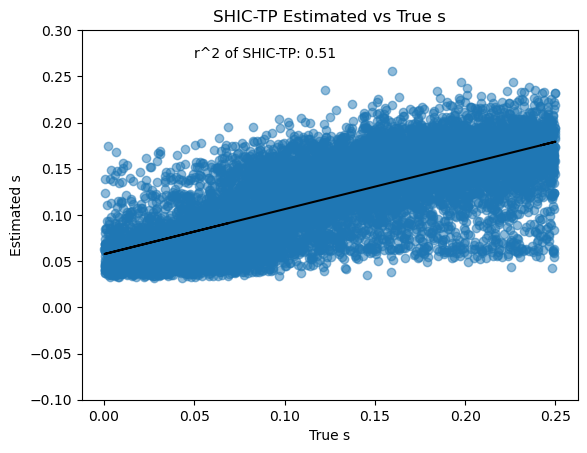

In [126]:
#Shic-TP
x = shic_ts["selcoeff"]
y = shic_ts["est_s"]

plt.scatter(x, y, alpha=0.5) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, "-", color="black")

plt.ylim((-0.1, 0.3))   
plt.annotate(
        f"""r^2 of SHIC-TP: {np.round(r2_score(x, y), 2)}""",
        (0.05, 0.27),
    )
plt.xlabel("True s")
plt.ylabel("Estimated s")
plt.title("SHIC-TP Estimated vs True s")
plt.savefig("shic_tp_selcoeffs.png")


In [127]:
ts = pd.read_csv("ts_res/ts_centers/AFT_Timesweeper_res.csv")
ts_hft = pd.read_csv("ts_res/ts_centers/hft_Timesweeper_res.csv")
sf = pd.read_csv("sf_res/sf_res.csv")
shic_final = pd.read_csv("shic_final_res/shic_res.csv")
shic_ts = pd.read_csv("shic_tp_res/TP_SHIC_res.csv")
stat_mets = pd.read_csv("stat_methods/stat_res.csv")

In [128]:
ts["swp_str"] = [lab_dict[i] for i in ts["sweep"]]
ts.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str
0,0,neut,0,0.900236,0.031182,0.068582,0.0,0.023495,0.157943,0
1,1,neut,0,0.967756,0.018013,0.014232,0.0,0.023938,0.048872,0
2,10,neut,0,0.944564,0.026852,0.028584,0.0,0.023861,0.115227,0
3,100,neut,0,0.914856,0.037577,0.047567,0.0,0.018109,0.073310,0
4,1001,neut,0,0.893581,0.014559,0.091860,0.0,0.025733,0.068648,0


[0.09976379 0.03224443 0.05543557 ... 0.51614693 0.99790595 0.90084127]
[0 0 0 ... 1 1 1]


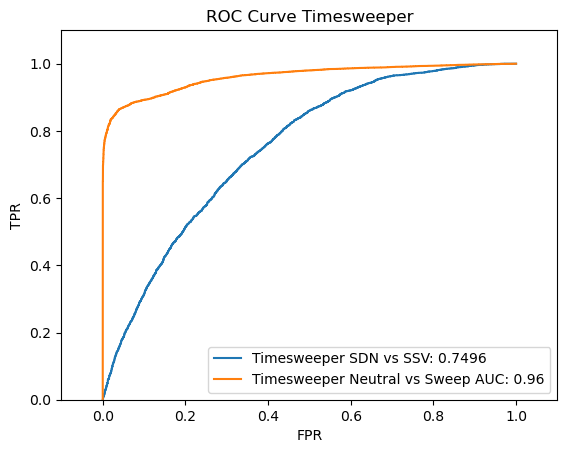

In [129]:
#Timesweeper
sweep_idxs = np.transpose(np.array((ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts["swp_str"])[sweep_idxs]

sdn_probs = ts[ts["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper SDN vs SSV: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts["sdn_prob"], ts["ssv_prob"]]).T, axis=1)
print(pred_probs)
print(labs)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Timesweeper Neutral vs Sweep AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve Timesweeper")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()


In [130]:
ts_hft["swp_str"] = [lab_dict[i] for i in ts_hft["sweep"]]
ts_hft.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,swp_str
0,0,neut,0,0.622819,0.079795,0.297386,0.0,0.084563,0.137496,0
1,1,neut,0,0.727708,0.096487,0.175805,0.0,0.032541,0.077407,0
2,10,neut,0,0.713442,0.083697,0.202861,0.0,0.031981,0.071435,0
3,100,neut,0,0.668812,0.136396,0.194792,0.0,0.056437,0.076022,0
4,1001,neut,0,0.692912,0.118566,0.188522,0.0,0.028734,0.057516,0


[0.37718088 0.27229245 0.28655835 ... 0.30897051 0.91114428 0.42087888]
[0 0 0 ... 1 1 1]


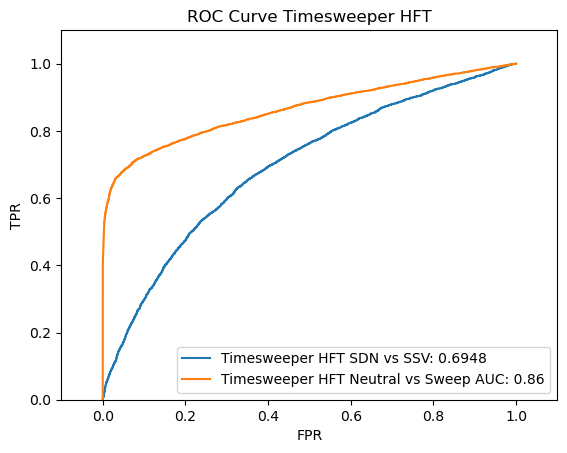

In [131]:
#Timesweeper
sweep_idxs = np.transpose(np.array((ts_hft["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts_hft["swp_str"])[sweep_idxs]

sdn_probs = ts_hft[ts_hft["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper HFT SDN vs SSV: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(ts_hft["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts_hft["sdn_prob"], ts_hft["ssv_prob"]]).T, axis=1)
print(pred_probs)
print(labs)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Timesweeper HFT Neutral vs Sweep AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve Timesweeper HFT")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

In [132]:
sf["int_swp"] = np.zeros(len(sf))
sf.loc[sf["sweep"] == "neut", "int_swp"] = 0
sf.loc[(sf["sweep"] == "sdn") | (sf["sweep"] == "ssv"), "int_swp"] = 1
sf.head()


,rep,sweep,pos,clr,pred,int_swp
0,0,neut,2.502531e+06,0.395412,neut,0.0
1,1,neut,2.502796e+06,0.425277,neut,0.0
2,10,neut,2.502128e+06,0.942135,neut,0.0
3,100,neut,2.501515e+06,1.233948,neut,0.0
4,1000,neut,2.502209e+06,0.137618,neut,0.0


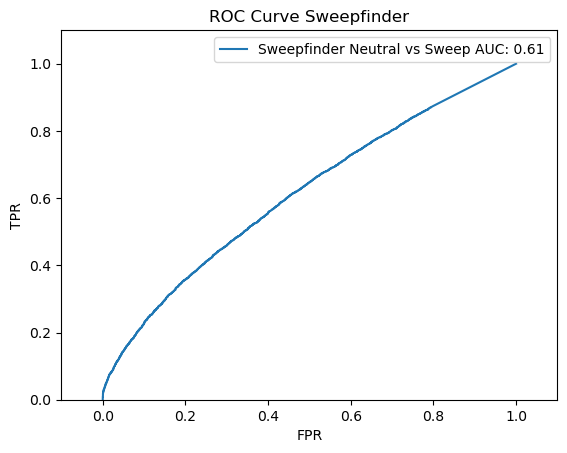

In [133]:
#Sweepfinder
fpr, tpr, thresh = roc_curve(sf["int_swp"], sf["clr"], pos_label=1)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Sweepfinder Neutral vs Sweep AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve Sweepfinder")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

In [134]:
shic_final.head()
shic_final = shic_final.loc[shic_final["window"] == 5, :]
#lab_dict = {"neut": 0, "hard": 1, "soft": 2, "linkedHard": 3, "linkedSoft": 4}
shic_final["sweep_prob"] = shic_final["soft_prob"] + shic_final["hard_prob"]

shic_final["int_swp"] = np.zeros(len(shic_final))
shic_final.loc[shic_final["sweep"] != "neut", "int_swp"] = 1
shic_final.loc[shic_final["sweep"] == "ssv", "int_swp"] = 2


shic_final
#shic_final["swp_str"] = [lab_dict[i] for i in shic_final["sweep"]]


,rep,sweep,window,pred,neut_prob,softlinked_prob,soft_prob,hard_prob,hardlinked_prob,sweep_prob,int_swp
6,0,neut,5,neutral,0.313869,0.277556,0.078079,0.032865,0.297631,0.110944,0.0
17,1,neut,5,neutral,0.318098,0.284763,0.058054,0.031846,0.307238,0.089900,0.0
28,10,neut,5,linkedHard,0.272664,0.268919,0.094440,0.083521,0.280456,0.177961,0.0
39,100,neut,5,soft,0.158889,0.155628,0.282539,0.248604,0.154340,0.531143,0.0
50,1000,neut,5,neutral,0.235058,0.223872,0.191793,0.121467,0.227811,0.313260,0.0
...,...,...,...,...,...,...,...,...,...,...,...
164969,995,ssv,5,hard,0.065456,0.062946,0.379667,0.408199,0.083733,0.787866,2.0
164980,996,ssv,5,linkedHard,0.268871,0.268391,0.118540,0.062019,0.282179,0.180559,2.0
164991,997,ssv,5,neutral,0.318941,0.285705,0.053238,0.047213,0.294903,0.100451,2.0
165002,998,ssv,5,soft,0.121098,0.110106,0.337763,0.307060,0.123973,0.644823,2.0


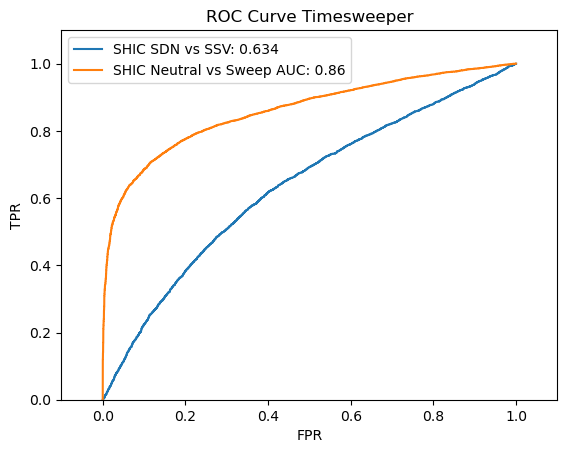

In [135]:
#Sweepfinder
sweep_idxs = np.transpose(np.array((shic_final["int_swp"] > 0)).nonzero())
sweep_labs = np.array(shic_final["int_swp"])[sweep_idxs]

sdn_probs = shic_final[shic_final["int_swp"] > 0]["hard_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"SHIC SDN vs SSV: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(shic_final["int_swp"])
labs[labs > 1] = 1

# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, shic_final["sweep_prob"])
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"SHIC Neutral vs Sweep AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve Timesweeper")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

In [136]:
shic_ts["swp_str"] = [lab_dict[i] for i in shic_ts["sweep"]]
shic_ts.head()

,rep,sweep,selcoeff,pred_class,neut_prob,sdn_prob,ssv_prob,sdn_pred_s,ssv_pred_s,swp_str
0,0,neut,0.194983,0,0.520371,0.202742,0.276887,0.061183,0.059168,0
1,0,sdn,0.068915,0,0.573763,0.190137,0.236100,0.033433,0.059415,1
2,0,ssv,0.014222,0,0.440146,0.236893,0.322961,0.080455,0.102627,2
3,1,neut,0.195803,0,0.601179,0.174347,0.224474,0.048792,0.061011,0
4,1,sdn,0.143512,1,0.083108,0.482789,0.434103,0.106391,0.130415,1


[0.47962956 0.42623694 0.55985353 ... 0.36547283 0.56494509 0.50488767]
[0 1 1 ... 0 1 1]


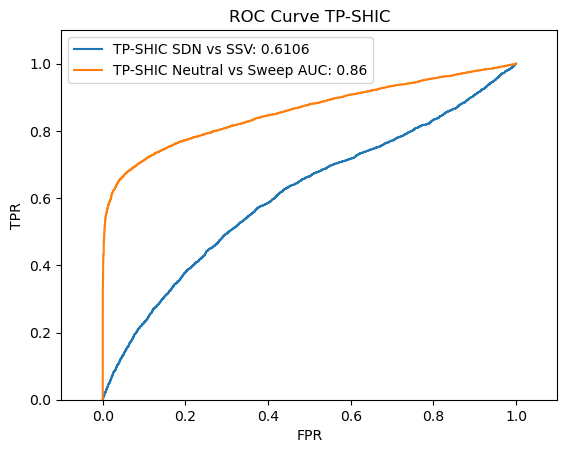

In [137]:
#Timesweeper
sweep_idxs = np.transpose(np.array((shic_ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(shic_ts["swp_str"])[sweep_idxs]

sdn_probs = shic_ts[shic_ts["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"TP-SHIC SDN vs SSV: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(shic_ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([shic_ts["sdn_prob"], shic_ts["ssv_prob"]]).T, axis=1)
print(pred_probs)
print(labs)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"TP-SHIC Neutral vs Sweep AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve TP-SHIC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

In [138]:
stat_mets.dropna(inplace=True)
stat_mets.head()

,rep,sweep,selcoeff,fit_pval,fet_pval
0,0,neut,0.0,0.391002,1.0
1,1,neut,0.0,0.961207,1.0
2,10,neut,0.0,0.357856,1.0
3,100,neut,0.0,0.902551,1.0
4,1001,neut,0.0,0.300681,1.0


In [139]:
stat_mets["fit_score"] = 1 - stat_mets["fit_pval"]
stat_mets["fet_score"] = 1 - stat_mets["fet_pval"]
stat_mets["int_swp"] = np.where(stat_mets["sweep"] == "neut", 0, 1)

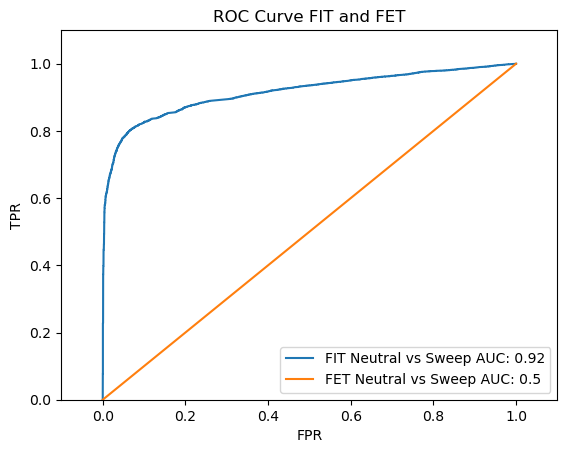

In [140]:
#Sweepfinder
fpr, tpr, thresh = roc_curve(stat_mets["int_swp"], stat_mets["fit_score"], pos_label=1)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"FIT Neutral vs Sweep AUC: {auc_val:.2}")

fpr, tpr, thresh = roc_curve(stat_mets["int_swp"], stat_mets["fet_score"], pos_label=1)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"FET Neutral vs Sweep AUC: {auc_val:.2}")

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curve FIT and FET")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

[0.37718088 0.27229245 0.28655835 ... 0.30897051 0.91114428 0.42087888]
[0 0 0 ... 1 1 1]


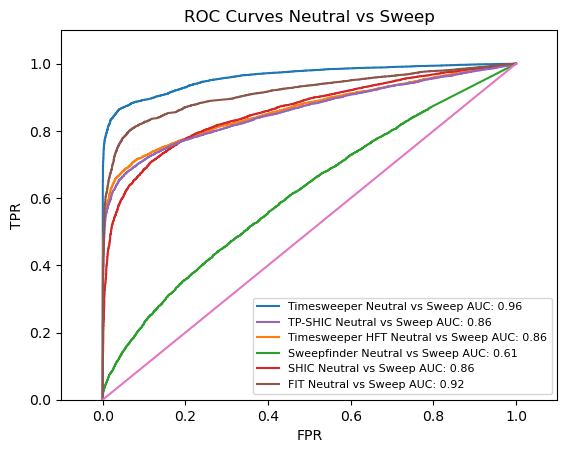

In [141]:
aucs = []
#Neut vs Sweep
#Timesweeper
# Coerce all ssvs into sweep binary pred
labs = np.array(ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts["sdn_prob"], ts["ssv_prob"]]).T, axis=1)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)
plt.plot(fpr, tpr, label=f"Timesweeper Neutral vs Sweep AUC: {auc_val:.2}")

###########
#HFT

# Coerce all ssvs into sweep binary pred
labs = np.array(ts_hft["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts_hft["sdn_prob"], ts_hft["ssv_prob"]]).T, axis=1)
print(pred_probs)
print(labs)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"Timesweeper HFT Neutral vs Sweep AUC: {auc_val:.2}")


###########
#Sweepfinder
fpr, tpr, thresh = roc_curve(sf["int_swp"], sf["clr"], pos_label=1)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Sweepfinder Neutral vs Sweep AUC: {auc_val:.2}")

###########
#SHIC
# Coerce all ssvs into sweep binary pred
labs = np.array(shic_final["int_swp"])
labs[labs > 1] = 1

# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, shic_final["sweep_prob"])
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"SHIC Neutral vs Sweep AUC: {auc_val:.2}")

###########
#TP-SHIC
# Coerce all ssvs into sweep binary pred
labs = np.array(shic_ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([shic_ts["sdn_prob"], shic_ts["ssv_prob"]]).T, axis=1)
# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"TP-SHIC Neutral vs Sweep AUC: {auc_val:.2}")

###########
#FIT
fpr, tpr, thresh = roc_curve(stat_mets["int_swp"], stat_mets["fit_score"], pos_label=1)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"FIT Neutral vs Sweep AUC: {auc_val:.2}")

###########
#FET
fpr, tpr, thresh = roc_curve(stat_mets["int_swp"], stat_mets["fet_score"], pos_label=1)
auc_val = auc(fpr, tpr)
aucs.append(auc_val)

plt.plot(fpr, tpr, label=f"FET Neutral vs Sweep AUC: {auc_val:.2}")

###########

#Plot 

handles, labels = plt.gca().get_legend_handles_labels()

order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(aucs))][::-1]

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curves Neutral vs Sweep")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=8)
plt.savefig("comp_methods_sweep_roc.pdf")


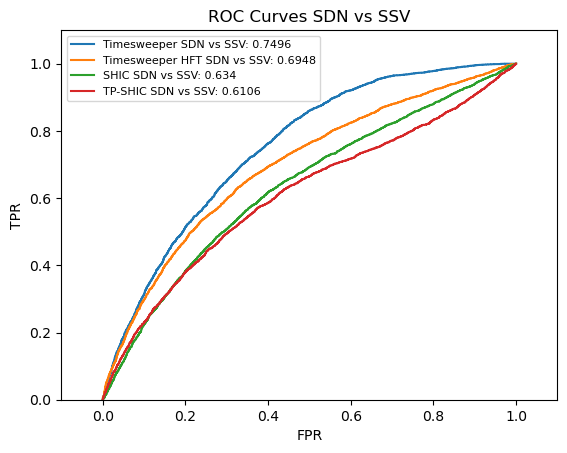

In [142]:
#Timesweeper
plt.clf()
sweep_idxs = np.transpose(np.array((ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts["swp_str"])[sweep_idxs]

sdn_probs = ts[ts["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper SDN vs SSV: {swp_auc_val:.4}",
)

#HFT
sweep_idxs = np.transpose(np.array((ts_hft["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts_hft["swp_str"])[sweep_idxs]

sdn_probs = ts_hft[ts_hft["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper HFT SDN vs SSV: {swp_auc_val:.4}",
)

#SHIC
sweep_idxs = np.transpose(np.array((shic_final["int_swp"] > 0)).nonzero())
sweep_labs = np.array(shic_final["int_swp"])[sweep_idxs]

sdn_probs = shic_final[shic_final["int_swp"] > 0]["hard_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"SHIC SDN vs SSV: {swp_auc_val:.4}",
)

#TP-SHIC
sweep_idxs = np.transpose(np.array((shic_ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(shic_ts["swp_str"])[sweep_idxs]

sdn_probs = shic_ts[shic_ts["swp_str"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"TP-SHIC SDN vs SSV: {swp_auc_val:.4}",
)
handles, labels = plt.gca().get_legend_handles_labels()

order = [0, 1, 2, 3]
plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"ROC Curves SDN vs SSV")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=8)
plt.savefig("comp_methods_sdnssv_roc.pdf")


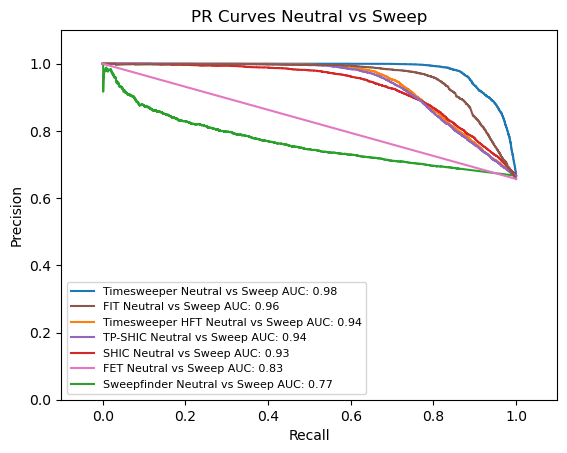

In [143]:
aucs = []
#Neut vs Sweep
#Timesweeper
# Coerce all ssvs into sweep binary pred
labs = np.array(ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts["sdn_prob"], ts["ssv_prob"]]).T, axis=1)
# Plot ROC Curve
prec, rec, thresh = precision_recall_curve(labs, pred_probs)
auc_val = auc(rec, prec)
aucs.append(auc_val)
plt.plot(rec, prec, label=f"Timesweeper Neutral vs Sweep AUC: {auc_val:.2}")

###########
#HFT

# Coerce all ssvs into sweep binary pred
labs = np.array(ts_hft["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([ts_hft["sdn_prob"], ts_hft["ssv_prob"]]).T, axis=1)

# Plot ROC Curve
prec, rec, thresh = precision_recall_curve(labs, pred_probs)
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"Timesweeper HFT Neutral vs Sweep AUC: {auc_val:.2}")


###########
#Sweepfinder
prec, rec, thresh = precision_recall_curve(sf["int_swp"], sf["clr"], pos_label=1)
auc_val = auc(rec, prec)
aucs.append(auc_val)
plt.plot(rec, prec, label=f"Sweepfinder Neutral vs Sweep AUC: {auc_val:.2}")

###########
#SHIC
# Coerce all ssvs into sweep binary pred
labs = np.array(shic_final["int_swp"])
labs[labs > 1] = 1

# Plot ROC Curve
prec, rec, thresh = precision_recall_curve(labs, shic_final["sweep_prob"])
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"SHIC Neutral vs Sweep AUC: {auc_val:.2}")

###########
#TP-SHIC
# Coerce all ssvs into sweep binary pred
labs = np.array(shic_ts["swp_str"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([shic_ts["sdn_prob"], shic_ts["ssv_prob"]]).T, axis=1)
# Plot ROC Curve
prec, rec, thresh = precision_recall_curve(labs, pred_probs)
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"TP-SHIC Neutral vs Sweep AUC: {auc_val:.2}")

###########
#FIT
prec, rec, thresh = precision_recall_curve(stat_mets["int_swp"], stat_mets["fit_score"], pos_label=1)
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"FIT Neutral vs Sweep AUC: {auc_val:.2}")

###########
#FET
prec, rec, thresh = precision_recall_curve(stat_mets["int_swp"], stat_mets["fet_score"], pos_label=1)
auc_val = auc(rec, prec)
aucs.append(auc_val)

plt.plot(rec, prec, label=f"FET Neutral vs Sweep AUC: {auc_val:.2}")

###########

#Plot 

handles, labels = plt.gca().get_legend_handles_labels()

order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(aucs))][::-1]

plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"PR Curves Neutral vs Sweep")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=8)
plt.savefig("comp_methods_sweep_pr.pdf")


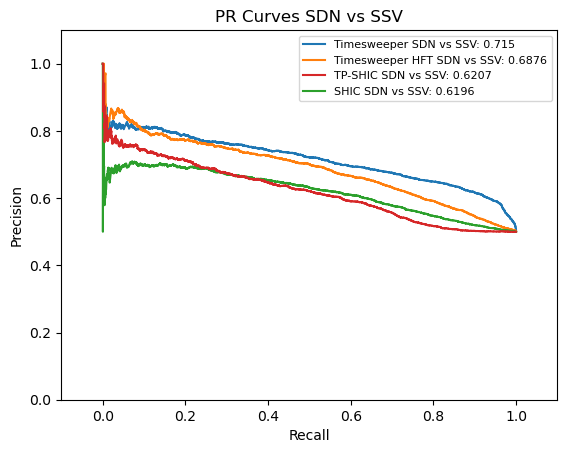

In [144]:
#Timesweeper
plt.clf()
sweep_idxs = np.transpose(np.array((ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts["swp_str"])[sweep_idxs]

sdn_probs = ts[ts["swp_str"] > 0]["sdn_prob"]

prec, rec, thresh = precision_recall_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(rec, prec)
plt.plot(
    rec,
    prec,
    label=f"Timesweeper SDN vs SSV: {swp_auc_val:.4}",
)

#HFT
sweep_idxs = np.transpose(np.array((ts_hft["swp_str"] > 0)).nonzero())
sweep_labs = np.array(ts_hft["swp_str"])[sweep_idxs]

sdn_probs = ts_hft[ts_hft["swp_str"] > 0]["sdn_prob"]

prec, rec, thresh = precision_recall_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(rec, prec)
plt.plot(
    rec,
    prec,
    label=f"Timesweeper HFT SDN vs SSV: {swp_auc_val:.4}",
)

#SHIC
sweep_idxs = np.transpose(np.array((shic_final["int_swp"] > 0)).nonzero())
sweep_labs = np.array(shic_final["int_swp"])[sweep_idxs]

sdn_probs = shic_final[shic_final["int_swp"] > 0]["hard_prob"]

prec, rec, thresh = precision_recall_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(rec, prec)
plt.plot(
    rec,
    prec,
    label=f"SHIC SDN vs SSV: {swp_auc_val:.4}",
)

#TP-SHIC
sweep_idxs = np.transpose(np.array((shic_ts["swp_str"] > 0)).nonzero())
sweep_labs = np.array(shic_ts["swp_str"])[sweep_idxs]

sdn_probs = shic_ts[shic_ts["swp_str"] > 0]["sdn_prob"]

prec, rec, thresh = precision_recall_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(rec, prec)
plt.plot(
    rec,
    prec,
    label=f"TP-SHIC SDN vs SSV: {swp_auc_val:.4}",
)
handles, labels = plt.gca().get_legend_handles_labels()

order = [0, 1, 3, 2]
plt.ylim((0,1.1))
plt.xlim((-0.1, 1.1))
plt.title(f"PR Curves SDN vs SSV")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=8)
plt.savefig("comp_methods_sdnssv_pr.pdf")
